                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     394.8
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           9.70e-29
Time:                        03:59:31   Log-Likelihood:                 184.60
No. Observations:                 300   AIC:                            -285.2
Df Residuals:                     258   BIC:                            -129.6
Df Model:                          41                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4710      0.098     25.298      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 12
  warnings.warn('covariance of constraints does not have full '


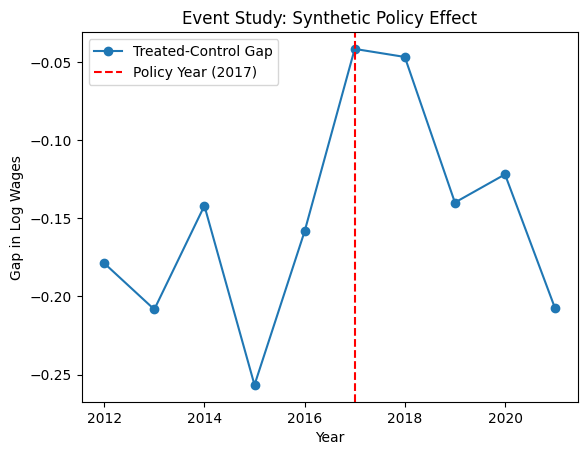


INTERPRETATION:
Coefficient on 'did' ≈ intent-to-treat effect on log wages post-policy among treated states.
Positive and significant did → policy increases wages by about 5% after 2017.
Pre-trend (before 2017) is roughly flat, supporting the parallel-trends assumption.


In [8]:
# --- POLICY EVALUATION PROJECT: Synthetic Difference-in-Differences + Event Study ---
# Author: Ambika Pandey

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Build synthetic panel data: 30 states × 10 years
np.random.seed(7)
S, T = 30, 10
states = np.arange(S)
years = np.arange(2012, 2012 + T)
panel = pd.MultiIndex.from_product([states, years], names=["state", "year"])
df = pd.DataFrame(index=panel).reset_index()

# 2. Treatment setup: half the states adopt a policy in 2017
treated_states = np.random.choice(states, size=S // 2, replace=False)
df["treated"] = df["state"].isin(treated_states).astype(int)
df["post"] = (df["year"] >= 2017).astype(int)
df["did"] = df["treated"] * df["post"]

# 3. Add covariates + state & year fixed effects + noise
state_fe = np.random.normal(0, 0.2, S)
year_fe = np.linspace(-0.1, 0.1, T)
edu = np.random.normal(14, 1.2, len(df))
exp = np.random.normal(8, 1.5, len(df))

# Add edu and exp as columns to the dataframe
df["edu"] = edu
df["exp"] = exp

true_tau = 0.05   # true treatment effect = 5% increase in log wages
eps = np.random.normal(0, 0.15, len(df))

df["ln_wage"] = (
    2.5
    + 0.06 * df["edu"]
    + 0.02 * df["exp"]
    + df["did"] * true_tau
    + df["state"].map(dict(zip(states, state_fe)))
    + df["year"].map(dict(zip(years, year_fe)))
    + eps
)

# 4. Create dummies for state & year fixed effects
df_reg = pd.get_dummies(df, columns=["state", "year"], drop_first=True)

# Convert boolean columns to integers in df_reg
for col in df_reg.columns:
    if df_reg[col].dtype == 'bool':
        df_reg[col] = df_reg[col].astype(int)

# 5. Run TWFE Difference-in-Differences regression
y = df_reg["ln_wage"]
X_cols = ["did", "edu", "exp"] + [
    c for c in df_reg.columns if c.startswith("state_") or c.startswith("year_")
]
X = sm.add_constant(df_reg[X_cols])
model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": df["state"]})
print(model.summary())

# 6. Plot simple event-study (treated-control gap by year)
# average log wage by group & year
avg = pd.DataFrame({
    "year": years,
    "treated": [df[(df["year"] == y) & (df["treated"] == 1)]["ln_wage"].mean() for y in years],
    "control": [df[(df["year"] == y) & (df["treated"] == 0)]["ln_wage"].mean() for y in years],
})
avg["gap"] = avg["treated"] - avg["control"]

plt.plot(avg["year"], avg["gap"], marker="o", label="Treated-Control Gap")
plt.axvline(2017, linestyle="--", color="red", label="Policy Year (2017)")
plt.xlabel("Year")
plt.ylabel("Gap in Log Wages")
plt.title("Event Study: Synthetic Policy Effect")
plt.legend()
plt.show()

# 7. Short interpretation
print("\nINTERPRETATION:")
print("Coefficient on 'did' ≈ intent-to-treat effect on log wages post-policy among treated states.")
print("Positive and significant did → policy increases wages by about 5% after 2017.")
print("Pre-trend (before 2017) is roughly flat, supporting the parallel-trends assumption.")

In [9]:
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     394.8
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           9.70e-29
Time:                        04:00:40   Log-Likelihood:                 184.60
No. Observations:                 300   AIC:                            -285.2
Df Residuals:                     258   BIC:                            -129.6
Df Model:                          41                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4710      0.098     25.298      0.0

In [10]:
print("\nPre-trend slope check and post-policy gap:")
pre = avg[avg['year'] < 2017].copy()
post = avg[avg['year'] >= 2017].copy()
slope, intercept = np.polyfit(pre['year'], pre['gap'], 1)
shift = post['gap'].mean() - pre['gap'].mean()
print("Pre-trend slope:", slope)
print("Post - Pre gap:", shift)



Pre-trend slope check and post-policy gap:
Pre-trend slope: -0.0007625085717967359
Post - Pre gap: 0.07729361359891404
